##Task-2 BoW_on_Flowers
###Submitted by: Muhammad Jawad Bashir
###Reg No: 330295 (MSDS20)

### Image recognition using Bag of words

In [1]:
from google.colab import drive
import os

if os.path.exists('/content/gdrive')==False:
    drive.mount('/content/gdrive')
    print('Google Drive is mounted\n')
else:
    print('Google Drive is already mounted\n')

Mounted at /content/gdrive
Google Drive is mounted



In [2]:
## Install older opencv package for using sift features
!pip install opencv-python==3.4.10.37
!pip install opencv-contrib-python==3.4.10.37

     |████████████████████████████████| 48.9 MB 62 kB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
     |████████████████████████████████| 54.5 MB 11 kB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [3]:
import cv2
import numpy as np
import os
from scipy.cluster.vq import kmeans, vq
from sklearn.preprocessing import StandardScaler
import pylab as pl
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.externals import joblib
import matplotlib.pyplot as plt
print(cv2.__version__)

3.4.10


/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [4]:
# dataset loading and preprocessing helper class
class BOVW:
  def __init__(self, dataset_path):
    self.dataset_path = dataset_path
    if "train" in os.listdir(self.dataset_path):
      self.train_path = os.path.join(self.dataset_path, "train")
      self.test_path = os.path.join(self.dataset_path, "test")
      self.train_test_split=False
    else:
      self.train_path = self.test_path = self.dataset_path
      self.train_test_split=True
  
  def get_img_paths_classes(self, mode='train'):
    if mode=="train":
      training_names = [x for x in os.listdir(self.train_path) if "." not in x]
      training_names.sort()
      print(training_names)
      folder = self.train_path
    else:
      training_names = [x for x in os.listdir(self.train_path) if "." not in x]
      training_names.sort()
      print(training_names)
      folder = self.test_path
    # Get path to all images and save them in a list
    # image_paths and the corresponding label in image_paths
    image_paths = []
    image_classes = []
    class_id = 0
    
    #To make it easy to list all file names in a directory let us define a function
    #
    def imglist(path):
      if self.train_test_split and mode=="train":
        files = [os.path.join(path, f) for f in os.listdir(path)]
        files.sort()
        newList = files[: int(len(files) * .80)]
      elif self.train_test_split and mode=="test":
        files = [os.path.join(path, f) for f in os.listdir(path)]
        files.sort()
        newList = files[int(len(files) * .80):]
      else:
        newList = [os.path.join(path, f) for f in os.listdir(path)]
        newList.sort()
      return newList
    
    #Fill the placeholder empty lists with image path, classes, and add class ID number
    #
    
    for training_name in training_names:
      dir = os.path.join(folder, training_name)
      class_path = imglist(dir)
      image_paths+=class_path
      image_classes+=[class_id]*len(class_path)
      class_id+=1
    return (image_paths, image_classes, class_id, training_names)

  def get_features_descriptors(self, image_paths, image_classes, class_id):
    # Create feature extraction and keypoint detector objects  
    # Create List where all the descriptors will be stored
    des_list = []
    orb = cv2.xfeatures2d.SIFT_create()
    for image_path in image_paths:
      im = cv2.imread(image_path)
      kpts, des = orb.detectAndCompute(im, None)
      des_list.append((image_path, des))   
    # Stack all the descriptors vertically in a numpy array
    descriptors = des_list[0][1]
    for image_path, descriptor in des_list[1:]:
      descriptors = np.vstack((descriptors, descriptor))  
    #kmeans works only on float, so convert integers to float
    descriptors_float = descriptors.astype(float)  
    return descriptors_float, des_list
  def get_final_features(self, descriptors_float, des_list, image_paths):
    # Perform k-means clustering and vector quantization

    k = 200  
    voc, variance = kmeans(descriptors_float, k, 1) 

    # Calculate the histogram of features and represent them as vector
    #vq Assigns codes from a code book to observations.
    im_features = np.zeros((len(image_paths), k), "float32")
    for i in range(len(image_paths)):
        words, distance = vq(des_list[i][1],voc)
        for w in words:
            im_features[i][w] += 1

    # Perform Tf-Idf vectorization
    nbr_occurences = np.sum( (im_features > 0) * 1, axis = 0)
    idf = np.array(np.log((1.0*len(image_paths)+1) / (1.0*nbr_occurences + 1)), 'float32')
    stdSlr = StandardScaler().fit(im_features)
    im_features = stdSlr.transform(im_features)
    return im_features, stdSlr, k, voc
  
  def get_features_test(self, descriptors_float, des_list, image_paths):
    # Calculate the histogram of features
    #vq Assigns codes from a code book to observations.  
    test_features = np.zeros((len(image_paths), k), "float32")
    for i in range(len(image_paths)):
        words, distance = vq(des_list[i][1],voc)
        for w in words:
            test_features[i][w] += 1

    # Perform Tf-Idf vectorization
    nbr_occurences = np.sum( (test_features > 0) * 1, axis = 0)
    idf = np.array(np.log((1.0*len(image_paths)+1) / (1.0*nbr_occurences + 1)), 'float32')

    # Scale the features
    #Standardize features by removing the mean and scaling to unit variance
    #Scaler (stdSlr comes from the pickled file we imported)
    test_features = stdSlr.transform(test_features)
    return test_features

  def train_and_save_model(self, im_features, image_classes, training_names,stdSlr, k, voc):
    #Train an algorithm to discriminate vectors corresponding to positive and negative training images
    # Train the Linear SVM
    from sklearn.svm import LinearSVC
    clf = LinearSVC(max_iter=100000)  #Default of 100 is not converging
    clf.fit(im_features, np.array(image_classes))

    #Train Random forest to compare how it does against SVM
    #from sklearn.ensemble import RandomForestClassifier
    #clf = RandomForestClassifier(n_estimators = 100, random_state=30)
    #clf.fit(im_features, np.array(image_classes))


    # Save the SVM
    #Joblib dumps Python object into one file
    from sklearn.externals import joblib
    joblib.dump((clf, training_names, stdSlr, k, voc), "bovw.pkl", compress=3) 
  
  def evaluate_model(self, clf, test_features, image_classes, classes_names):
    #Report true class names so they can be compared with predicted classes
    true_class =  [classes_names[i] for i in image_classes]
    # Perform the predictions and report predicted class names. 
    predictions =  [classes_names[i] for i in clf.predict(test_features)]

    #Print the true class and Predictions 
    print ("true_class ="  + str(true_class))
    print ("prediction ="  + str(predictions))

    def showconfusionmatrix(cm):
      pl.matshow(cm)
      pl.title('Confusion matrix')
      pl.colorbar()
      pl.show()

    accuracy = accuracy_score(true_class, predictions)
    print ("accuracy = ", accuracy)
    c_mat = confusion_matrix(true_class, predictions)
    print (c_mat)
    showconfusionmatrix(c_mat)

    false_positives = c_mat.sum(axis=0) - np.diag(c_mat)  
    false_negatives = c_mat.sum(axis=1) - np.diag(c_mat)
    true_positives = np.diag(c_mat)
    true_negatives = c_mat.sum() - (false_positives + false_negatives + true_positives)
    print(true_positives, false_positives, true_negatives, false_negatives)
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = true_positives/(true_positives+false_negatives)
    # Specificity or true negative rate
    TNR = true_negatives/(true_negatives+false_positives) 
    # Precision or positive predictive value
    PPV = true_positives/(true_positives+false_positives)
    # Negative predictive value
    NPV = true_negatives/(true_negatives+false_negatives)
    # Fall out or false positive rate
    FPR = false_positives/(false_positives+true_negatives)
    # False negative rate
    FNR = false_negatives/(true_positives+false_negatives)
    # False discovery rate
    FDR = false_positives/(true_positives+false_positives)

    # Overall accuracy
    ACC = (true_positives+true_negatives)/(true_positives+false_positives+false_negatives+true_negatives)

    print("true positive rate: ",TPR, "false positive rate: ",FPR)
    print("Accuracy: ", ACC)

    ## Precision and recall and f-1 score for positive class
    precision = float(true_positives[1]) / (true_positives[1] + false_positives[1])
    recall = float(true_positives[1]) / (true_positives[1] + false_negatives[1])

    f1 = 2*precision*recall / (precision + recall)

    print ("Precision: " + str(precision), "Recall: " + str(recall))
    print ("F1 Score: " + str(f1))
    return true_class, predictions

In [5]:
!pwd

/content


### Loading train dataset and training

In [8]:
## loading dataset
dataset_path = "/content/gdrive/MyDrive/flower_photos_file/flower_photos"
bovw = BOVW(dataset_path)
image_paths, image_classes, class_id, training_names = bovw.get_img_paths_classes(mode='train')
descriptors_float, des_list = bovw.get_features_descriptors(image_paths, image_classes, class_id)
im_features, stdSlr, k, voc=bovw.get_final_features(descriptors_float, des_list, image_paths)
bovw.train_and_save_model(im_features, image_classes, training_names, stdSlr, k, voc)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


### Loading test data and testing

In [9]:
# Load the classifier, class names, scaler, number of clusters and vocabulary 
#from stored pickle file (generated during training)
clf, classes_names, stdSlr, k, voc = joblib.load("bovw.pkl")

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
true_class =['daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'dai

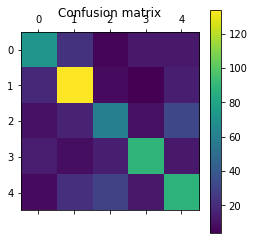

[ 72 134  60  89  88] [51 71 58 40 73] [558 485 549 556 503] [55 46 69 51 72]
true positive rate:  [0.56692913 0.74444444 0.46511628 0.63571429 0.55      ] false positive rate:  [0.08374384 0.12769784 0.09555189 0.06711409 0.12673611]
Accuracy:  [0.85597826 0.84103261 0.82744565 0.8763587  0.80298913]
Precision: 0.6536585365853659 Recall: 0.7444444444444445
F1 Score: 0.6961038961038961


In [10]:
image_paths, image_classes, class_id, training_names = bovw.get_img_paths_classes(mode='test')
descriptors_float, des_list = bovw.get_features_descriptors(image_paths, image_classes, class_id)
test_features=bovw.get_features_test(descriptors_float, des_list, image_paths)
true_class, predictions=bovw.evaluate_model(clf, test_features, image_classes, classes_names)

In [11]:
print(classification_report(true_class, predictions))

              precision    recall  f1-score   support

       daisy       0.59      0.57      0.58       127
   dandelion       0.65      0.74      0.70       180
       roses       0.51      0.47      0.49       129
  sunflowers       0.69      0.64      0.66       140
      tulips       0.55      0.55      0.55       160

    accuracy                           0.60       736
   macro avg       0.60      0.59      0.59       736
weighted avg       0.60      0.60      0.60       736



### Visualizing predictions

['/content/gdrive/MyDrive/flower_photos_file/flower_photos/daisy/5948835387_5a98d39eff_m.jpg', '/content/gdrive/MyDrive/flower_photos_file/flower_photos/daisy/5973488341_50bdf6cee3_n.jpg', '/content/gdrive/MyDrive/flower_photos_file/flower_photos/daisy/5973491805_556bba93cc.jpg', '/content/gdrive/MyDrive/flower_photos_file/flower_photos/daisy/5981645737_29eceac291_m.jpg', '/content/gdrive/MyDrive/flower_photos_file/flower_photos/daisy/5997702776_c7bc37aa6b_n.jpg', '/content/gdrive/MyDrive/flower_photos_file/flower_photos/daisy/6054952060_c88612f3c5_n.jpg', '/content/gdrive/MyDrive/flower_photos_file/flower_photos/daisy/6089825811_80f253fbe1.jpg', '/content/gdrive/MyDrive/flower_photos_file/flower_photos/daisy/6095817094_3a5b1d793d.jpg', '/content/gdrive/MyDrive/flower_photos_file/flower_photos/daisy/6136947177_47ff445eb4_n.jpg', '/content/gdrive/MyDrive/flower_photos_file/flower_photos/daisy/6148728633_27afc47b0c_m.jpg', '/content/gdrive/MyDrive/flower_photos_file/flower_photos/daisy/6

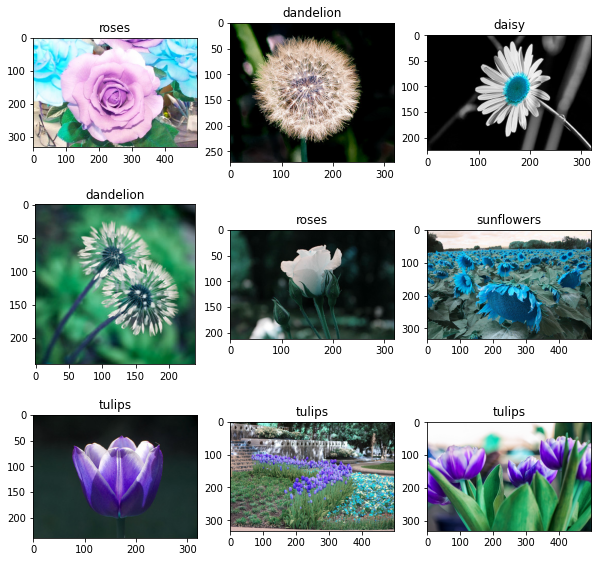

Plotting wrong predictions...


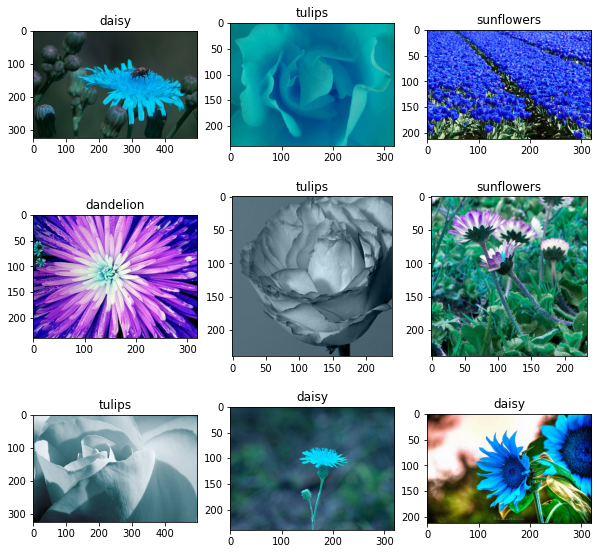

In [12]:
print(image_paths, image_classes, class_id, training_names)
# print(type(true_class))
correct_preds = np.array(true_class) == np.array(predictions)
#print(type(test_data.y))
print(sum(correct_preds), correct_preds[:10])
### Showing correct predictions
print("Showing correct predictions...")
correct_inds, incorrect_inds = [],[]
for i,x in enumerate(correct_preds):
  if x:
    correct_inds.append(i)
  else:
    incorrect_inds.append(i)
#print(correct_inds, incorrect_inds)
correct_inds = set(np.random.choice(correct_inds, size=9))
incorrect_inds = set(np.random.choice(incorrect_inds, size=9))
print(correct_inds, incorrect_inds)

print("Plotting correct predictions...")
imgs, labels = [], []
for i,x in enumerate(correct_inds):
  imgs.append(cv2.imread(image_paths[x]))
  labels.append(predictions[x])
_, axs = plt.subplots(3, 3, figsize=(10, 10))
axs = axs.flatten()
for img, ax, l in zip(imgs, axs, labels):
    #print(img)
    ax.imshow(img)
    ax.set_title(l)
plt.show()

print("Plotting wrong predictions...")
imgs, labels = [], []
for i,x in enumerate(incorrect_inds):
  imgs.append(cv2.imread(image_paths[x]))
  labels.append(predictions[x])
_, axs = plt.subplots(3, 3, figsize=(10, 10))
axs = axs.flatten()
for img, ax, l in zip(imgs, axs, labels):
    #print(img)
    ax.imshow(img)
    ax.set_title(l)
plt.show()